<a href="https://colab.research.google.com/github/ZackWongAPO/Colab/blob/main/LinearRegressionAir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#加载库

In [1]:
# 库的加载

# general
import io

# data processing
import numpy
import pandas
from sklearn.model_selection import train_test_split

# machine learning support
import keras

# data visualization
import plotly.express as px
import plotly.subplots as sb
import plotly.graph_objects as go
import seaborn

from google.colab import files
from keras.callbacks import EarlyStopping
from keras.callbacks import LambdaCallback

#加载空气污染数据集

In [2]:
uploaded = files.upload()

Saving AirPollutionDefault.xlsx to AirPollutionDefault.xlsx


#数据预处理
>数据预处理和特征工程详见pandas.ipynb，此处不再赘述，重点研究如何抽取训练集与测试集

>>由于数据与季节，年份有很大的关系，因此抽取数据分三种方式，这三个代码选择其一执行

In [21]:
# 日期正常排列，不作任何处理
df = pandas.read_excel('/content/AirPollutionDefault.xlsx')
print(df.head())
label = df['PM25']
print(label.head())
feature = df[['Date']]
# 'AQI', 'PM10', 'SO2', 'CO', 'NO2', 'O3_8h'
print(feature.head())

# X的意思是特征值，y的意思是标签值
feature_train, feature_test, AQI_train, AQI_test = train_test_split(feature, label, test_size=0.15, random_state=12)
features_train = feature_train.values
features_test = feature_test.values
AQIs_train = AQI_train.values
AQIs_test = AQI_test.values

print(feature_train.head())
print(feature_test.head())
print(AQI_train.head())
print(AQI_test.head())

   Date  year  month  day  AQI  PM25  PM10   SO2   CO  NO2  O3_8h
0     1  2013     12    2  145   111   163  89.0  1.7   85   42.0
1     2  2013     12    3  356   306   299  98.0  1.9  127   21.0
2     3  2013     12    4  314   264   230  98.0  1.5  144   24.0
3     4  2013     12    5  170   129   162  59.0  1.3   80   36.0
4     5  2013     12    6   55    39    61  45.0  0.9   76   36.0
0    111
1    306
2    264
3    129
4     39
Name: PM25, dtype: int64
   Date
0     1
1     2
2     3
3     4
4     5
      Date
2109  2110
1901  1902
1392  1393
685    686
1476  1477
      Date
536    537
634    635
903    904
1687  1688
190    191
2109     9
1901    37
1392    35
685     38
1476    20
Name: PM25, dtype: int64
536     28
634     25
903     44
1687    11
190     35
Name: PM25, dtype: int64


In [ ]:
# 删除臭氧特征值，进行数据归一化后训练
df = pandas.read_xls('/content/AirPollution01.xlsx')
print(df.head())

In [ ]:
# 进一步拆分年月日，每周内按照随机数抽选训练集与测试集
df = pandas.read_xls('/content/AirPollution01Final.xlsx')
print(df.head())

#编写训练函数
>包括机器学习模型的选择，深度学习神经元个数与层数的设计，模型的编译，训练超参数的输入等等

In [26]:
# 封装各机器学习细节至总函数

# 建立简单线性模型
def build_linear_model(my_learning_rate, num_features):
  # 大多数模型都是序列模型，无脑建模就可以
  model = keras.models.Sequential()

  # 添加全连接层
  # unit表示神经元个数，只添加一层就只有一个输出层，一个神经元意味着只有一条直线
  # input_shape 是输入数据的形状，对于大多数神经网络的输入层而言都是一维向量
  model.add(keras.layers.Dense(units=1,input_shape=(num_features,)))

  # 编译模型，从而加速训练速度

  # optimizer：优化器，用于控制梯度裁剪。必选项。在此处修改流程图中的三种优化器方法
  # 方法一：keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)（随机梯度下降法）
  # 方法二：keras.optimizers.SGD(lr=0.01, momentum=0.5, decay=0.0, nesterov=True)（带动量版本的SGD）
  # 方法三：keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)(理论最优)
  # lr: float >= 0. 学习率。
  # momentum : float>= 0. 动量值参数，用于加速 SGD 在相关方向上前进，并抑制震荡。
  # decay: float >= 0. 每次参数更新后学习率衰减值，可有效防止模型不收敛。
  # nesterov: boolean. 是否使用 Nesterov 动量。

  # loss：损失函数（或称目标函数、优化评分函数）。必选项
  # metrics：评价函数用于评估当前训练模型的性能。
  # 当模型编译后（compile），评价函数应该作为 metrics 的参数来输入。
  # 评价函数和损失函数相似，只不过评价函数的结果不会用于训练过程中，只应用于测试集。
  model.compile(optimizer=keras.optimizers.SGD(learning_rate=my_learning_rate),
                loss="mean_squared_error",
                metrics=[keras.metrics.RootMeanSquaredError()])

  return model


def train_model(model, features, label, epochs, batch_size):

  # # 定义回调函数，当loss值不再明显变化的时候会提前结束训练
  # early_stopping = EarlyStopping(monitor='val_loss', patience=2)

  # 开始训练模型
  # batch_size：将一整个数据集随机分成多个小块(batch)，可以有效增加模型的收敛速度
  # epochs：纪元数，相当于刷新权重值矩阵的次数
  # x：输入特征值训练集，格式为Numpy数组
  # y：输入标签值训练集，格式为Numpy数组
  # 返回的是一个history对象，其属性值为连续epoch纪元值所对应的Loss值和评价值

  history = model.fit( x=features,
              y=label,
              batch_size=batch_size,
              epochs=epochs,
              # callbacks=[early_stopping]
              )

  # 得到最终训练结果的权重和偏差
  trained_weight = model.get_weights()[0]
  trained_bias = model.get_weights()[1]

  # 返回纪元值列表
  epochs = history.epoch
  print(type(epochs))

  # 将每个纪元值所对应的Loss值和评价值转化为pandas表格，用于作图
  hist = pandas.DataFrame(history.history)

  print(hist.head())
  return trained_weight, trained_bias, hist

#编写验证函数
>因为训练数据都是通过归一化的，所以预测时的输入应该也是归一化模型

调用上述函数

In [27]:
linear_model = build_linear_model(0.0000001, 1)
trained_weight, trained_bias, hist = train_model(model = linear_model,
                                features = features_train,
                                label = AQIs_train,
                                epochs = 500,
                                batch_size = 400)

Epoch 1/500


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1867591.0000 - root_mean_squared_error: 1343.6855  
Epoch 2/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 34687.4570 - root_mean_squared_error: 183.5697 
Epoch 3/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2259.8748 - root_mean_squared_error: 47.4456 
Epoch 4/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1630.2094 - root_mean_squared_error: 40.3736 
Epoch 5/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1731.2874 - root_mean_squared_error: 41.5983 
Epoch 6/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1649.0101 - root_mean_squared_error: 40.6075 
Epoch 7/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1552.4199 - root_mean_squared_error: 39.3835 
Epoch 8/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1794.4199 - root_mean_squared_error: 42.3314 
Epoch 9/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1586.8013 - root_mean_squared_error: 39.8268 
Epoch 10/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1628.7573 - root_me

In [28]:
print(trained_weight)
print(trained_bias)

[[0.02344975]]
[0.00574289]


#编写画图函数

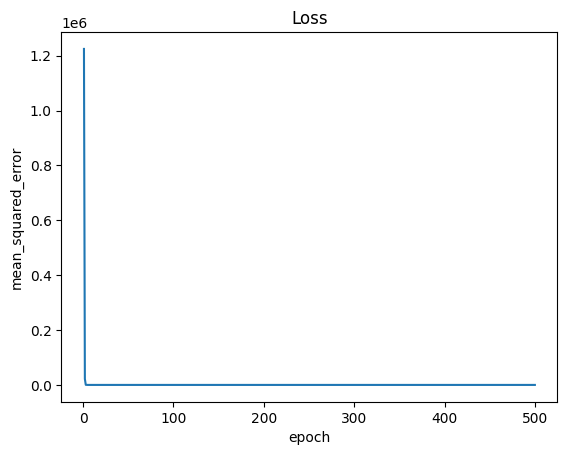

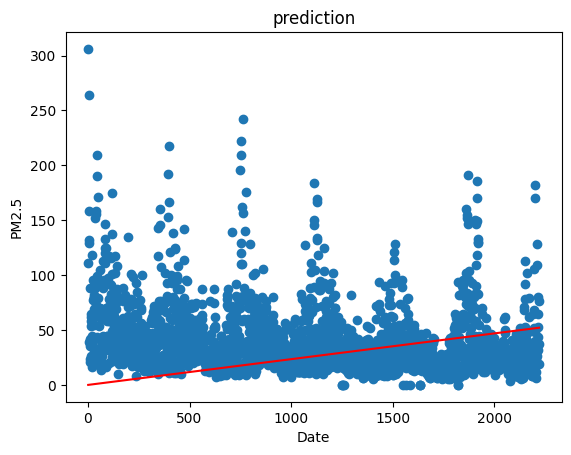

In [37]:
import matplotlib.pyplot as plt

loss = hist['loss']
epoch = range(1,len(loss)+1)

plt.figure(1)
plt.title('Loss')
plt.ylabel('mean_squared_error')
plt.xlabel('epoch')
plt.plot(epoch, loss)

plt.figure(2)
plt.title('prediction')
plt.ylabel('PM2.5')
plt.xlabel('Date')
plt.scatter(feature, label)
predict = trained_bias + trained_weight * feature.values
plt.plot(feature, predict, color = 'red')
